# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [20]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

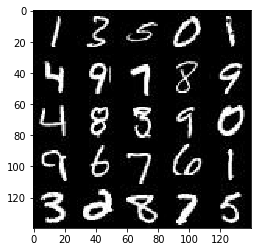

In [21]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join('./data', 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

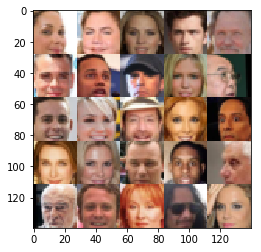

In [22]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeb_images = helper.get_batch(glob(os.path.join(data_dir,'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeb_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [ ]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real=tf.placeholder(tf.float32, (None, image_width, image_height, image_channels) , name='input_real')
    input_z =tf.placeholder(tf.float32, (None, z_dim) , name='input_z')
    lr = tf.placeholder(tf.float32,  name ='learning_rate')
    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [25]:
alpha = 0.01
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same' )
        x1 = tf.maximum(alpha*x1, x1)
        #16*16*64
#         print(x1.shape)
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same' )
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        #8*8*128
#         print(x2.shape)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same' )
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        #4*4*256
#         print(x3.shape)
        
        flats = tf.reshape(x3, [-1, 4*4*256])
        logits = tf.layers.dense( flats, 1,activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [58]:
alpha=0.2
keep_prob=0.75
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1=tf.layers.dense(z, 7*7*512)
        x1=tf.reshape(x1, [-1,7,7,512])
        x1=tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        print("x1",x1.shape)
        x2=tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2=tf.layers.batch_normalization(x2, training=is_train)
        x2=tf.maximum(alpha * x2, x2)
        x1 = tf.nn.dropout(x1, keep_prob=keep_prob)
        print("x2",x2.shape)
        x3=tf.layers.conv2d_transpose(x2, 32, 5, strides=2, padding='same')
        x3=tf.layers.batch_normalization(x3, training=is_train)
        x3=tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=keep_prob)
        print("x3",x3.shape)
        
#         x4=tf.layers.conv2d_transpose(x3, 8, 5, strides=2, padding='same')
#         x4=tf.layers.batch_normalization(x4, training=is_train)
#         x4=tf.maximum(alpha * x4, x4)
#         print("x4",x4.shape)
        # Output layer, 28*28*3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
#         logits=tf.reshape(logits, [-1,28,28,out_channel_dim])
        print("logits",logits.shape)
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 5)
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [59]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model =  generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    smooth = 0.1
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, 
                                                                         labels = tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    d_loss= d_loss_real+d_loss_fake
    g_loss =tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)) )
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [60]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [61]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [62]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
#                 print("batch_images", len(batch_images))
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
            


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)
Epoch 0/2... Discriminator Loss: 0.4296... Generator Loss: 3.5508
Epoch 0/2... Discriminator Loss: 2.7514... Generator Loss: 0.1392
Epoch 0/2... Discriminator Loss: 0.6251... Generator Loss: 2.4387
Epoch 0/2... Discriminator Loss: 1.7351... Generator Loss: 0.3646
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


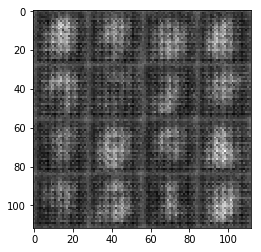

Epoch 0/2... Discriminator Loss: 1.2462... Generator Loss: 1.4624
Epoch 0/2... Discriminator Loss: 0.6189... Generator Loss: 2.0964
Epoch 0/2... Discriminator Loss: 0.8158... Generator Loss: 1.4113
Epoch 0/2... Discriminator Loss: 0.7793... Generator Loss: 1.9874
Epoch 0/2... Discriminator Loss: 0.6980... Generator Loss: 1.9592
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


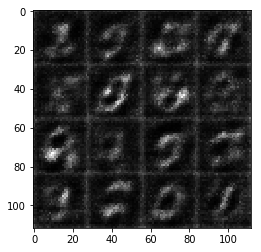

Epoch 0/2... Discriminator Loss: 0.6470... Generator Loss: 1.7775
Epoch 0/2... Discriminator Loss: 0.6877... Generator Loss: 1.5998
Epoch 0/2... Discriminator Loss: 0.5254... Generator Loss: 1.9910
Epoch 0/2... Discriminator Loss: 0.6040... Generator Loss: 3.7870
Epoch 0/2... Discriminator Loss: 0.4643... Generator Loss: 3.3457
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


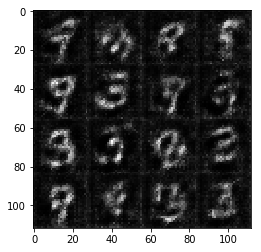

Epoch 0/2... Discriminator Loss: 0.3908... Generator Loss: 3.3415
Epoch 0/2... Discriminator Loss: 0.3722... Generator Loss: 3.8731
Epoch 0/2... Discriminator Loss: 0.3677... Generator Loss: 3.9232
Epoch 0/2... Discriminator Loss: 0.3646... Generator Loss: 3.9160
Epoch 0/2... Discriminator Loss: 0.3597... Generator Loss: 4.0134
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


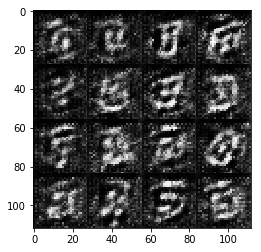

Epoch 0/2... Discriminator Loss: 0.3488... Generator Loss: 4.5955
Epoch 0/2... Discriminator Loss: 0.3577... Generator Loss: 4.6434
Epoch 0/2... Discriminator Loss: 0.4543... Generator Loss: 3.1938
Epoch 0/2... Discriminator Loss: 0.3435... Generator Loss: 4.8588
Epoch 0/2... Discriminator Loss: 0.3414... Generator Loss: 4.7536
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


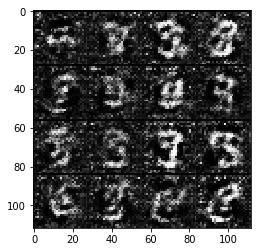

Epoch 0/2... Discriminator Loss: 0.3370... Generator Loss: 5.4459
Epoch 0/2... Discriminator Loss: 0.3438... Generator Loss: 4.8167
Epoch 0/2... Discriminator Loss: 0.3693... Generator Loss: 4.4577
Epoch 0/2... Discriminator Loss: 11.3574... Generator Loss: 16.9150
Epoch 0/2... Discriminator Loss: 0.5244... Generator Loss: 2.0097
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


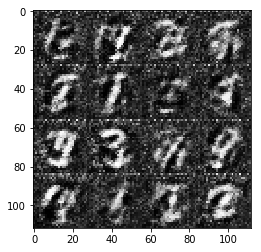

Epoch 0/2... Discriminator Loss: 0.4601... Generator Loss: 2.6734
Epoch 0/2... Discriminator Loss: 0.3580... Generator Loss: 4.1070
Epoch 0/2... Discriminator Loss: 0.3570... Generator Loss: 3.9889
Epoch 0/2... Discriminator Loss: 0.4054... Generator Loss: 3.7347
Epoch 0/2... Discriminator Loss: 0.3552... Generator Loss: 4.2141
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


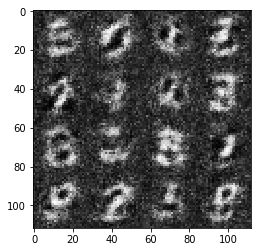

Epoch 0/2... Discriminator Loss: 0.8220... Generator Loss: 1.1102
Epoch 0/2... Discriminator Loss: 0.4678... Generator Loss: 2.3648
Epoch 0/2... Discriminator Loss: 0.3662... Generator Loss: 3.8025
Epoch 0/2... Discriminator Loss: 0.3639... Generator Loss: 4.3566
Epoch 0/2... Discriminator Loss: 0.4969... Generator Loss: 2.8243
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


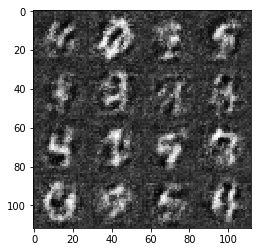

Epoch 0/2... Discriminator Loss: 0.4408... Generator Loss: 3.4320
Epoch 0/2... Discriminator Loss: 0.3970... Generator Loss: 3.5655
Epoch 0/2... Discriminator Loss: 0.4151... Generator Loss: 2.8934
Epoch 0/2... Discriminator Loss: 3.5264... Generator Loss: 0.0791
Epoch 0/2... Discriminator Loss: 0.6085... Generator Loss: 2.8701
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


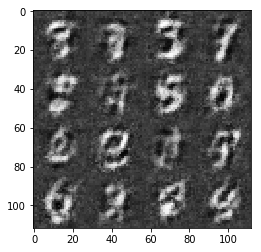

Epoch 0/2... Discriminator Loss: 0.5259... Generator Loss: 2.1317
Epoch 0/2... Discriminator Loss: 0.4690... Generator Loss: 2.6108
Epoch 1/2... Discriminator Loss: 0.4654... Generator Loss: 2.4154
Epoch 1/2... Discriminator Loss: 2.1362... Generator Loss: 5.9974
Epoch 1/2... Discriminator Loss: 0.5815... Generator Loss: 2.4679
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


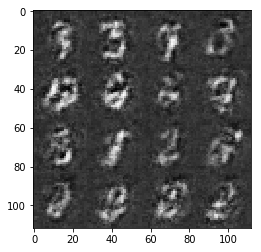

Epoch 1/2... Discriminator Loss: 0.5269... Generator Loss: 2.0116
Epoch 1/2... Discriminator Loss: 0.4443... Generator Loss: 2.8988
Epoch 1/2... Discriminator Loss: 0.4631... Generator Loss: 2.3657
Epoch 1/2... Discriminator Loss: 1.9969... Generator Loss: 0.3409
Epoch 1/2... Discriminator Loss: 0.7205... Generator Loss: 3.3177
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


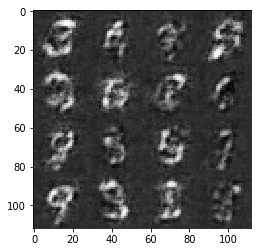

Epoch 1/2... Discriminator Loss: 0.4945... Generator Loss: 2.2491
Epoch 1/2... Discriminator Loss: 0.4502... Generator Loss: 2.5539
Epoch 1/2... Discriminator Loss: 0.4262... Generator Loss: 2.6240
Epoch 1/2... Discriminator Loss: 0.3812... Generator Loss: 3.6270
Epoch 1/2... Discriminator Loss: 0.5281... Generator Loss: 1.9714
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


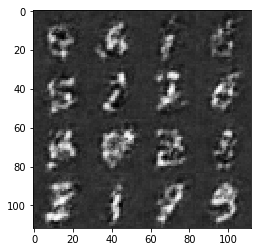

Epoch 1/2... Discriminator Loss: 0.4761... Generator Loss: 2.2037
Epoch 1/2... Discriminator Loss: 0.4095... Generator Loss: 2.8968
Epoch 1/2... Discriminator Loss: 0.4936... Generator Loss: 2.1818
Epoch 1/2... Discriminator Loss: 0.3966... Generator Loss: 3.3228
Epoch 1/2... Discriminator Loss: 0.3781... Generator Loss: 3.3722
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


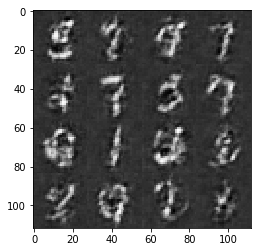

Epoch 1/2... Discriminator Loss: 0.3896... Generator Loss: 3.2133
Epoch 1/2... Discriminator Loss: 0.3894... Generator Loss: 3.6004
Epoch 1/2... Discriminator Loss: 3.8425... Generator Loss: 2.6500
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 0.7006
Epoch 1/2... Discriminator Loss: 0.5364... Generator Loss: 2.0232
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


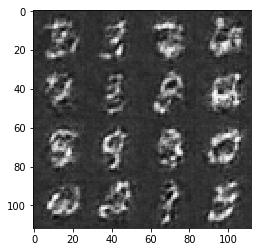

Epoch 1/2... Discriminator Loss: 0.4593... Generator Loss: 2.4411
Epoch 1/2... Discriminator Loss: 0.4633... Generator Loss: 2.3328
Epoch 1/2... Discriminator Loss: 0.4170... Generator Loss: 2.8976
Epoch 1/2... Discriminator Loss: 0.4092... Generator Loss: 2.9024
Epoch 1/2... Discriminator Loss: 0.4156... Generator Loss: 2.9104
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


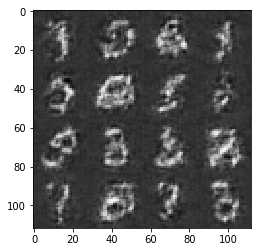

Epoch 1/2... Discriminator Loss: 0.4122... Generator Loss: 2.6230
Epoch 1/2... Discriminator Loss: 0.3965... Generator Loss: 2.8964
Epoch 1/2... Discriminator Loss: 0.4027... Generator Loss: 2.9719
Epoch 1/2... Discriminator Loss: 0.3774... Generator Loss: 3.5291
Epoch 1/2... Discriminator Loss: 0.3665... Generator Loss: 3.6895
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


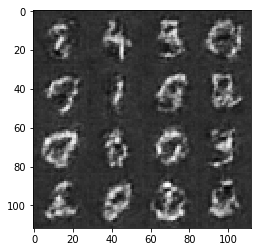

Epoch 1/2... Discriminator Loss: 0.4227... Generator Loss: 2.5722
Epoch 1/2... Discriminator Loss: 0.5411... Generator Loss: 3.0487
Epoch 1/2... Discriminator Loss: 1.7088... Generator Loss: 2.7961
Epoch 1/2... Discriminator Loss: 0.8996... Generator Loss: 1.3207
Epoch 1/2... Discriminator Loss: 0.6726... Generator Loss: 1.4385
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


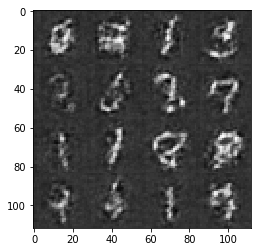

Epoch 1/2... Discriminator Loss: 0.4825... Generator Loss: 2.9610
Epoch 1/2... Discriminator Loss: 0.4340... Generator Loss: 2.5589
Epoch 1/2... Discriminator Loss: 0.5474... Generator Loss: 1.9383
Epoch 1/2... Discriminator Loss: 0.3954... Generator Loss: 3.3407
Epoch 1/2... Discriminator Loss: 0.3997... Generator Loss: 2.7089
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 1)


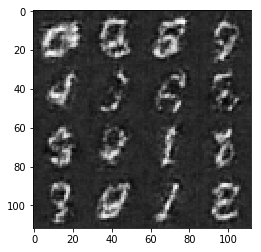

Epoch 1/2... Discriminator Loss: 0.3731... Generator Loss: 3.9677
Epoch 1/2... Discriminator Loss: 0.3636... Generator Loss: 4.1635
Epoch 1/2... Discriminator Loss: 0.3683... Generator Loss: 3.7487
Epoch 1/2... Discriminator Loss: 0.3563... Generator Loss: 4.1171
CPU times: user 2min 3s, sys: 42.7 s, total: 2min 46s
Wall time: 4min 53s


In [63]:
%%time
batch_size = 128
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5
alpha=0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2
# tf.reset_default_graph()
        
mnist_dataset = helper.Dataset('mnist', glob(os.path.join('./data', 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

finished loading images.
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)
Epoch 0/1... Discriminator Loss: 0.5347... Generator Loss: 2.7134
Epoch 0/1... Discriminator Loss: 0.4883... Generator Loss: 2.8117
Epoch 0/1... Discriminator Loss: 0.8961... Generator Loss: 6.9141
Epoch 0/1... Discriminator Loss: 0.8335... Generator Loss: 1.3074
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


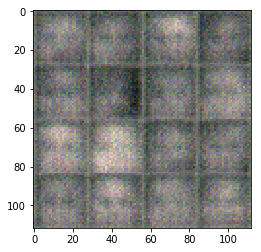

Epoch 0/1... Discriminator Loss: 0.6410... Generator Loss: 1.6839
Epoch 0/1... Discriminator Loss: 0.5588... Generator Loss: 2.0569
Epoch 0/1... Discriminator Loss: 0.4327... Generator Loss: 3.0103
Epoch 0/1... Discriminator Loss: 0.4207... Generator Loss: 3.7201
Epoch 0/1... Discriminator Loss: 0.3840... Generator Loss: 3.7436
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


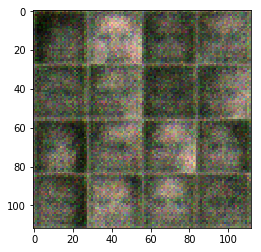

Epoch 0/1... Discriminator Loss: 0.4055... Generator Loss: 3.7962
Epoch 0/1... Discriminator Loss: 0.3666... Generator Loss: 4.0432
Epoch 0/1... Discriminator Loss: 0.3554... Generator Loss: 4.8912
Epoch 0/1... Discriminator Loss: 0.3834... Generator Loss: 3.6017
Epoch 0/1... Discriminator Loss: 0.3906... Generator Loss: 5.3948
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


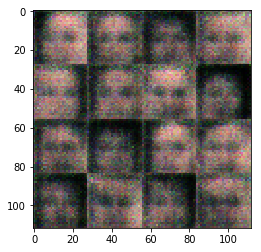

Epoch 0/1... Discriminator Loss: 0.4777... Generator Loss: 5.4265
Epoch 0/1... Discriminator Loss: 0.3593... Generator Loss: 4.2188
Epoch 0/1... Discriminator Loss: 0.3461... Generator Loss: 4.8991
Epoch 0/1... Discriminator Loss: 0.3496... Generator Loss: 5.0856
Epoch 0/1... Discriminator Loss: 0.3648... Generator Loss: 4.2921
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


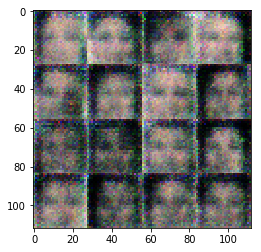

Epoch 0/1... Discriminator Loss: 0.3467... Generator Loss: 4.5826
Epoch 0/1... Discriminator Loss: 0.3422... Generator Loss: 5.1037
Epoch 0/1... Discriminator Loss: 0.3406... Generator Loss: 4.7908
Epoch 0/1... Discriminator Loss: 0.3428... Generator Loss: 5.3297
Epoch 0/1... Discriminator Loss: 0.3366... Generator Loss: 5.5086
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


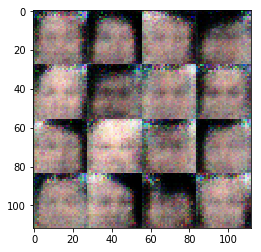

Epoch 0/1... Discriminator Loss: 0.4500... Generator Loss: 3.0825
Epoch 0/1... Discriminator Loss: 0.3532... Generator Loss: 4.4633
Epoch 0/1... Discriminator Loss: 0.3411... Generator Loss: 5.0839
Epoch 0/1... Discriminator Loss: 0.3391... Generator Loss: 5.4364
Epoch 0/1... Discriminator Loss: 0.3587... Generator Loss: 4.9677
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


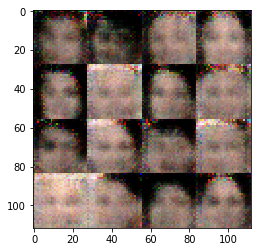

Epoch 0/1... Discriminator Loss: 0.3522... Generator Loss: 5.7739
Epoch 0/1... Discriminator Loss: 0.3389... Generator Loss: 5.2076
Epoch 0/1... Discriminator Loss: 0.3453... Generator Loss: 4.5434
Epoch 0/1... Discriminator Loss: 0.3642... Generator Loss: 5.1029
Epoch 0/1... Discriminator Loss: 0.3511... Generator Loss: 5.0696
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


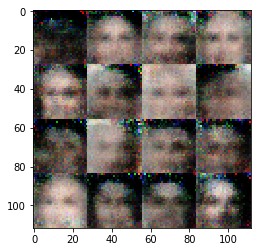

Epoch 0/1... Discriminator Loss: 0.5163... Generator Loss: 6.3150
Epoch 0/1... Discriminator Loss: 0.4644... Generator Loss: 3.2670
Epoch 0/1... Discriminator Loss: 0.3683... Generator Loss: 4.3408
Epoch 0/1... Discriminator Loss: 0.4150... Generator Loss: 2.9332
Epoch 0/1... Discriminator Loss: 0.5790... Generator Loss: 2.0272
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


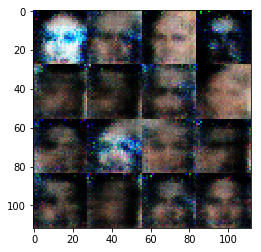

Epoch 0/1... Discriminator Loss: 0.3661... Generator Loss: 3.5117
Epoch 0/1... Discriminator Loss: 0.3924... Generator Loss: 3.6429
Epoch 0/1... Discriminator Loss: 0.5221... Generator Loss: 2.2732
Epoch 0/1... Discriminator Loss: 0.3970... Generator Loss: 3.3564
Epoch 0/1... Discriminator Loss: 0.3805... Generator Loss: 3.8876
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


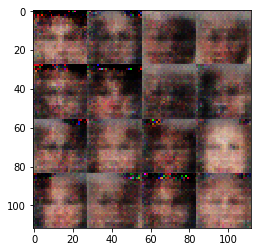

Epoch 0/1... Discriminator Loss: 0.4418... Generator Loss: 3.3183
Epoch 0/1... Discriminator Loss: 0.5403... Generator Loss: 2.2428
Epoch 0/1... Discriminator Loss: 0.4113... Generator Loss: 4.0215
Epoch 0/1... Discriminator Loss: 0.7924... Generator Loss: 1.3348
Epoch 0/1... Discriminator Loss: 0.4942... Generator Loss: 2.6628
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


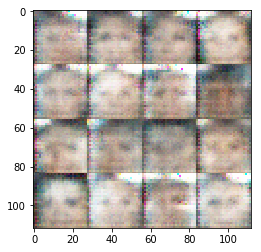

Epoch 0/1... Discriminator Loss: 0.4547... Generator Loss: 4.2671
Epoch 0/1... Discriminator Loss: 0.3774... Generator Loss: 4.7343
Epoch 0/1... Discriminator Loss: 0.3879... Generator Loss: 3.4071
Epoch 0/1... Discriminator Loss: 0.3774... Generator Loss: 3.7205
Epoch 0/1... Discriminator Loss: 0.4156... Generator Loss: 3.8280
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


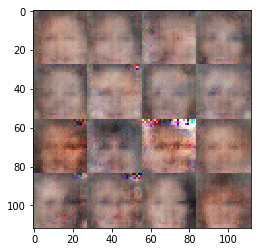

Epoch 0/1... Discriminator Loss: 0.3704... Generator Loss: 4.0454
Epoch 0/1... Discriminator Loss: 0.9632... Generator Loss: 5.2365
Epoch 0/1... Discriminator Loss: 0.4883... Generator Loss: 3.1796
Epoch 0/1... Discriminator Loss: 0.4034... Generator Loss: 4.0875
Epoch 0/1... Discriminator Loss: 0.4136... Generator Loss: 4.2429
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


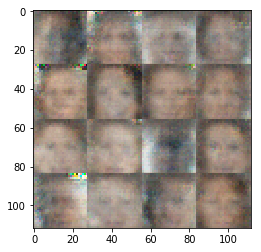

Epoch 0/1... Discriminator Loss: 0.3981... Generator Loss: 3.3677
Epoch 0/1... Discriminator Loss: 0.4024... Generator Loss: 4.2692
Epoch 0/1... Discriminator Loss: 0.4455... Generator Loss: 3.2286
Epoch 0/1... Discriminator Loss: 0.5148... Generator Loss: 3.1490
Epoch 0/1... Discriminator Loss: 0.4513... Generator Loss: 3.9091
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


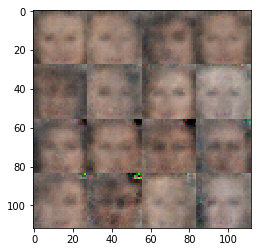

Epoch 0/1... Discriminator Loss: 0.4278... Generator Loss: 3.7662
Epoch 0/1... Discriminator Loss: 0.4256... Generator Loss: 3.0952
Epoch 0/1... Discriminator Loss: 1.9081... Generator Loss: 0.3593
Epoch 0/1... Discriminator Loss: 0.7890... Generator Loss: 2.1258
Epoch 0/1... Discriminator Loss: 0.7682... Generator Loss: 2.4199
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


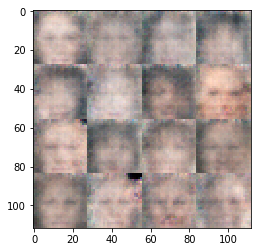

Epoch 0/1... Discriminator Loss: 1.1128... Generator Loss: 1.1570
Epoch 0/1... Discriminator Loss: 0.9473... Generator Loss: 1.8537
Epoch 0/1... Discriminator Loss: 1.1704... Generator Loss: 1.0509
Epoch 0/1... Discriminator Loss: 0.9119... Generator Loss: 1.1906
Epoch 0/1... Discriminator Loss: 1.2722... Generator Loss: 0.8590
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


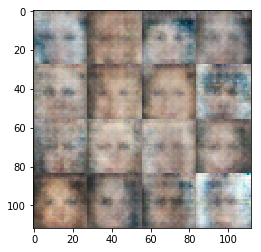

Epoch 0/1... Discriminator Loss: 0.8723... Generator Loss: 1.2361
Epoch 0/1... Discriminator Loss: 0.7870... Generator Loss: 1.6400
Epoch 0/1... Discriminator Loss: 1.1807... Generator Loss: 0.8215
Epoch 0/1... Discriminator Loss: 1.2850... Generator Loss: 1.1987
Epoch 0/1... Discriminator Loss: 1.4123... Generator Loss: 0.6606
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


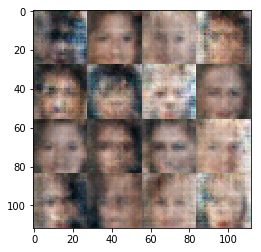

Epoch 0/1... Discriminator Loss: 0.8876... Generator Loss: 1.5946
Epoch 0/1... Discriminator Loss: 1.2803... Generator Loss: 0.7647
Epoch 0/1... Discriminator Loss: 1.2833... Generator Loss: 0.6102
Epoch 0/1... Discriminator Loss: 1.1462... Generator Loss: 0.9130
Epoch 0/1... Discriminator Loss: 1.2582... Generator Loss: 0.7050
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


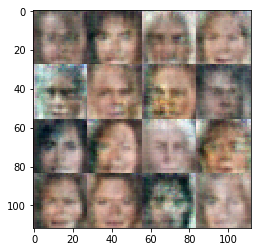

Epoch 0/1... Discriminator Loss: 1.0392... Generator Loss: 1.6709
Epoch 0/1... Discriminator Loss: 1.1557... Generator Loss: 1.5373
Epoch 0/1... Discriminator Loss: 1.1669... Generator Loss: 0.9602
Epoch 0/1... Discriminator Loss: 1.3000... Generator Loss: 2.7289
Epoch 0/1... Discriminator Loss: 1.0615... Generator Loss: 1.6714
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


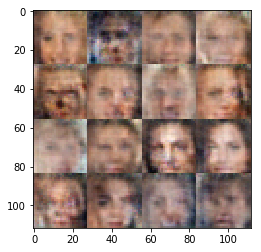

Epoch 0/1... Discriminator Loss: 0.9622... Generator Loss: 1.1576
Epoch 0/1... Discriminator Loss: 0.9568... Generator Loss: 1.1207
Epoch 0/1... Discriminator Loss: 1.0081... Generator Loss: 1.0313
Epoch 0/1... Discriminator Loss: 1.2141... Generator Loss: 0.8814
Epoch 0/1... Discriminator Loss: 1.1669... Generator Loss: 1.8966
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


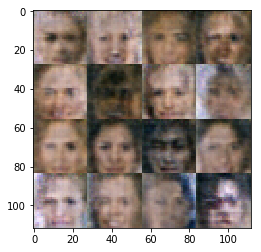

Epoch 0/1... Discriminator Loss: 1.0905... Generator Loss: 1.3497
Epoch 0/1... Discriminator Loss: 1.2836... Generator Loss: 0.7041
Epoch 0/1... Discriminator Loss: 1.1822... Generator Loss: 0.7262
Epoch 0/1... Discriminator Loss: 1.0293... Generator Loss: 0.9282
Epoch 0/1... Discriminator Loss: 0.9633... Generator Loss: 1.2124
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


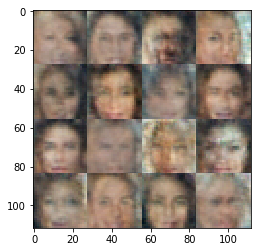

Epoch 0/1... Discriminator Loss: 1.0689... Generator Loss: 1.6283
Epoch 0/1... Discriminator Loss: 0.9671... Generator Loss: 1.6407
Epoch 0/1... Discriminator Loss: 0.9215... Generator Loss: 1.4371
Epoch 0/1... Discriminator Loss: 0.8665... Generator Loss: 1.2557
Epoch 0/1... Discriminator Loss: 1.1888... Generator Loss: 1.0333
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


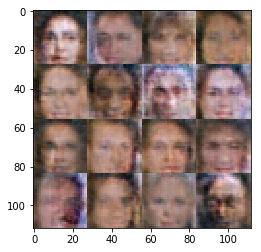

Epoch 0/1... Discriminator Loss: 1.0299... Generator Loss: 1.2288
Epoch 0/1... Discriminator Loss: 1.0547... Generator Loss: 1.6528
Epoch 0/1... Discriminator Loss: 0.9438... Generator Loss: 1.9018
Epoch 0/1... Discriminator Loss: 0.9087... Generator Loss: 1.1255
Epoch 0/1... Discriminator Loss: 1.0798... Generator Loss: 1.3127
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


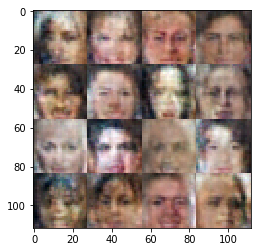

Epoch 0/1... Discriminator Loss: 1.0901... Generator Loss: 0.8704
Epoch 0/1... Discriminator Loss: 1.1003... Generator Loss: 1.3540
Epoch 0/1... Discriminator Loss: 0.9166... Generator Loss: 1.2892
Epoch 0/1... Discriminator Loss: 1.0224... Generator Loss: 1.1006
Epoch 0/1... Discriminator Loss: 1.0936... Generator Loss: 0.8852
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


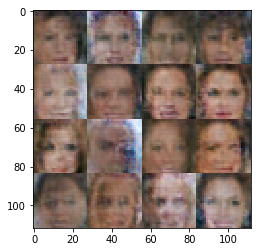

Epoch 0/1... Discriminator Loss: 1.1335... Generator Loss: 0.8269
Epoch 0/1... Discriminator Loss: 1.0559... Generator Loss: 2.1010
Epoch 0/1... Discriminator Loss: 1.0090... Generator Loss: 1.7494
Epoch 0/1... Discriminator Loss: 1.0128... Generator Loss: 0.9121
Epoch 0/1... Discriminator Loss: 0.9888... Generator Loss: 1.3769
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


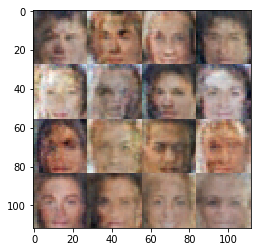

Epoch 0/1... Discriminator Loss: 0.8519... Generator Loss: 1.6719
Epoch 0/1... Discriminator Loss: 0.8778... Generator Loss: 1.5034
Epoch 0/1... Discriminator Loss: 0.9491... Generator Loss: 1.0795
Epoch 0/1... Discriminator Loss: 0.8477... Generator Loss: 1.4431
Epoch 0/1... Discriminator Loss: 0.9598... Generator Loss: 1.2264
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


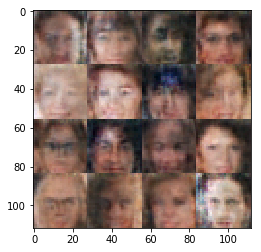

Epoch 0/1... Discriminator Loss: 1.1824... Generator Loss: 0.6853
Epoch 0/1... Discriminator Loss: 1.1565... Generator Loss: 1.6727
Epoch 0/1... Discriminator Loss: 1.1786... Generator Loss: 0.7406
Epoch 0/1... Discriminator Loss: 0.9296... Generator Loss: 1.4268
Epoch 0/1... Discriminator Loss: 0.8481... Generator Loss: 1.6018
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


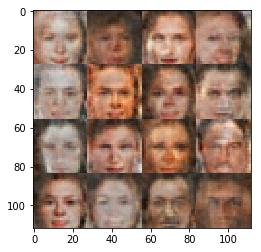

Epoch 0/1... Discriminator Loss: 0.9388... Generator Loss: 1.3367
Epoch 0/1... Discriminator Loss: 1.1131... Generator Loss: 2.0888
Epoch 0/1... Discriminator Loss: 1.4200... Generator Loss: 2.0390
Epoch 0/1... Discriminator Loss: 0.9774... Generator Loss: 1.2011
Epoch 0/1... Discriminator Loss: 0.7944... Generator Loss: 1.2508
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


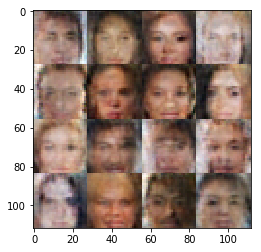

Epoch 0/1... Discriminator Loss: 1.0323... Generator Loss: 1.3934
Epoch 0/1... Discriminator Loss: 1.0324... Generator Loss: 0.9208
Epoch 0/1... Discriminator Loss: 1.1026... Generator Loss: 0.8051
Epoch 0/1... Discriminator Loss: 0.9515... Generator Loss: 2.0660
Epoch 0/1... Discriminator Loss: 0.9574... Generator Loss: 0.9580
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


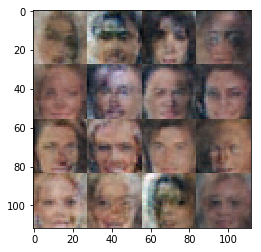

Epoch 0/1... Discriminator Loss: 0.9747... Generator Loss: 1.0969
Epoch 0/1... Discriminator Loss: 1.0820... Generator Loss: 1.4052
Epoch 0/1... Discriminator Loss: 1.2050... Generator Loss: 0.6068
Epoch 0/1... Discriminator Loss: 1.0348... Generator Loss: 0.9009
Epoch 0/1... Discriminator Loss: 0.8855... Generator Loss: 1.0335
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


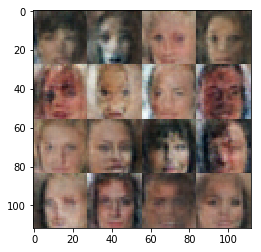

Epoch 0/1... Discriminator Loss: 0.8846... Generator Loss: 0.9563
Epoch 0/1... Discriminator Loss: 1.0536... Generator Loss: 1.5102
Epoch 0/1... Discriminator Loss: 0.9909... Generator Loss: 1.0800
Epoch 0/1... Discriminator Loss: 1.2542... Generator Loss: 0.6326
Epoch 0/1... Discriminator Loss: 1.2257... Generator Loss: 1.2470
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


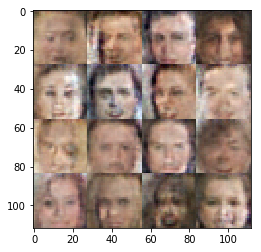

Epoch 0/1... Discriminator Loss: 1.3038... Generator Loss: 0.5616
Epoch 0/1... Discriminator Loss: 1.2202... Generator Loss: 0.5663
Epoch 0/1... Discriminator Loss: 1.3238... Generator Loss: 0.5895
Epoch 0/1... Discriminator Loss: 1.1095... Generator Loss: 1.6290
Epoch 0/1... Discriminator Loss: 0.9158... Generator Loss: 1.1648
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


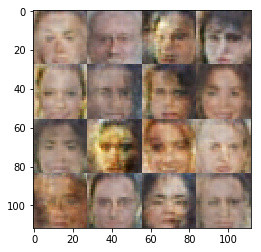

Epoch 0/1... Discriminator Loss: 0.9934... Generator Loss: 2.2675
Epoch 0/1... Discriminator Loss: 1.0241... Generator Loss: 1.6383
Epoch 0/1... Discriminator Loss: 0.8718... Generator Loss: 1.2299
Epoch 0/1... Discriminator Loss: 1.2195... Generator Loss: 0.6030
Epoch 0/1... Discriminator Loss: 0.9642... Generator Loss: 1.0463
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


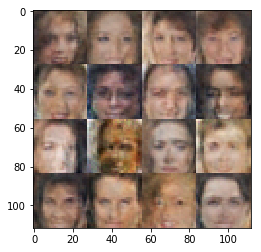

Epoch 0/1... Discriminator Loss: 1.0233... Generator Loss: 1.3767
Epoch 0/1... Discriminator Loss: 0.9690... Generator Loss: 1.4929
Epoch 0/1... Discriminator Loss: 0.8579... Generator Loss: 1.3419
Epoch 0/1... Discriminator Loss: 0.9063... Generator Loss: 1.3892
Epoch 0/1... Discriminator Loss: 1.0394... Generator Loss: 1.1372
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


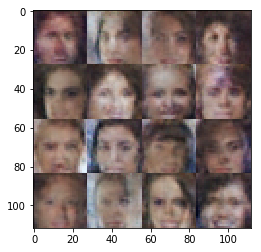

Epoch 0/1... Discriminator Loss: 0.9413... Generator Loss: 0.9393
Epoch 0/1... Discriminator Loss: 0.9082... Generator Loss: 0.9366
Epoch 0/1... Discriminator Loss: 1.0741... Generator Loss: 0.9172
Epoch 0/1... Discriminator Loss: 0.9923... Generator Loss: 1.5369
Epoch 0/1... Discriminator Loss: 0.9241... Generator Loss: 1.1336
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


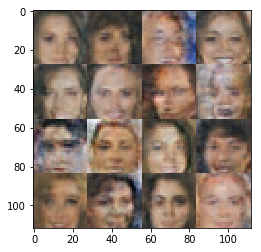

Epoch 0/1... Discriminator Loss: 1.0208... Generator Loss: 0.9701
Epoch 0/1... Discriminator Loss: 0.9535... Generator Loss: 1.2759
Epoch 0/1... Discriminator Loss: 0.7226... Generator Loss: 1.4261
Epoch 0/1... Discriminator Loss: 0.9835... Generator Loss: 0.9503
Epoch 0/1... Discriminator Loss: 1.0155... Generator Loss: 1.0000
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


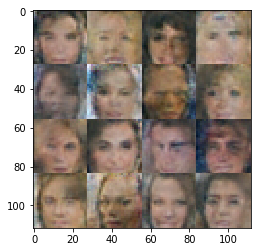

Epoch 0/1... Discriminator Loss: 1.2798... Generator Loss: 1.7522
Epoch 0/1... Discriminator Loss: 0.9179... Generator Loss: 1.4799
Epoch 0/1... Discriminator Loss: 1.1806... Generator Loss: 0.7859
Epoch 0/1... Discriminator Loss: 0.9429... Generator Loss: 1.0969
Epoch 0/1... Discriminator Loss: 0.9334... Generator Loss: 1.4406
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


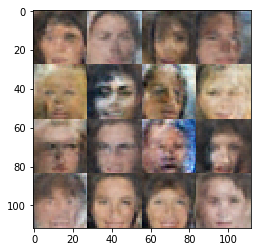

Epoch 0/1... Discriminator Loss: 0.9217... Generator Loss: 1.0129
Epoch 0/1... Discriminator Loss: 1.1267... Generator Loss: 0.7435
Epoch 0/1... Discriminator Loss: 1.0454... Generator Loss: 0.6677
Epoch 0/1... Discriminator Loss: 1.9168... Generator Loss: 0.2836
Epoch 0/1... Discriminator Loss: 0.9444... Generator Loss: 1.3735
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


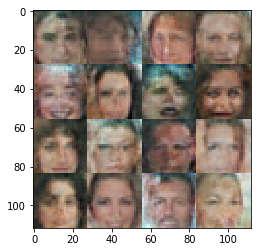

Epoch 0/1... Discriminator Loss: 1.0960... Generator Loss: 0.7698
Epoch 0/1... Discriminator Loss: 1.1985... Generator Loss: 0.6325
Epoch 0/1... Discriminator Loss: 0.9679... Generator Loss: 1.2871
Epoch 0/1... Discriminator Loss: 1.0736... Generator Loss: 0.8000
Epoch 0/1... Discriminator Loss: 1.0241... Generator Loss: 1.3007
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


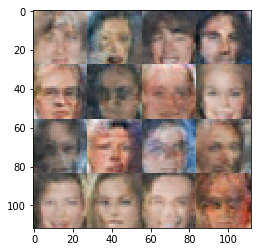

Epoch 0/1... Discriminator Loss: 1.1063... Generator Loss: 1.2705
Epoch 0/1... Discriminator Loss: 1.1490... Generator Loss: 0.8454
Epoch 0/1... Discriminator Loss: 1.3712... Generator Loss: 0.5894
Epoch 0/1... Discriminator Loss: 0.9889... Generator Loss: 0.9856
Epoch 0/1... Discriminator Loss: 0.9672... Generator Loss: 1.2517
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


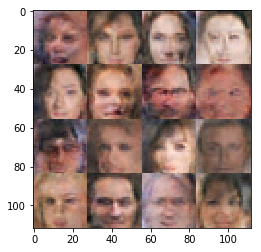

Epoch 0/1... Discriminator Loss: 1.1489... Generator Loss: 1.5574
Epoch 0/1... Discriminator Loss: 1.0952... Generator Loss: 0.7557
Epoch 0/1... Discriminator Loss: 1.0736... Generator Loss: 0.8229
Epoch 0/1... Discriminator Loss: 1.0457... Generator Loss: 0.9307
Epoch 0/1... Discriminator Loss: 1.0555... Generator Loss: 0.7530
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


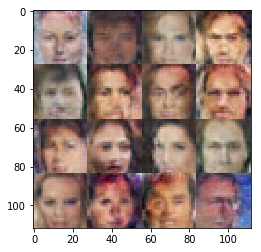

Epoch 0/1... Discriminator Loss: 1.1161... Generator Loss: 1.6772
Epoch 0/1... Discriminator Loss: 1.0892... Generator Loss: 0.8900
Epoch 0/1... Discriminator Loss: 0.7649... Generator Loss: 1.5878
Epoch 0/1... Discriminator Loss: 0.9767... Generator Loss: 0.9540
Epoch 0/1... Discriminator Loss: 1.0258... Generator Loss: 0.8788
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


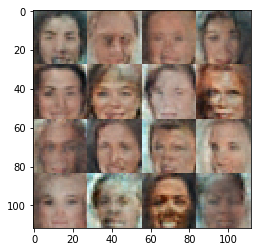

Epoch 0/1... Discriminator Loss: 1.1037... Generator Loss: 0.7275
Epoch 0/1... Discriminator Loss: 0.9823... Generator Loss: 1.0301
Epoch 0/1... Discriminator Loss: 1.0728... Generator Loss: 0.9261
Epoch 0/1... Discriminator Loss: 1.0098... Generator Loss: 0.9158
Epoch 0/1... Discriminator Loss: 0.9959... Generator Loss: 2.0056
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


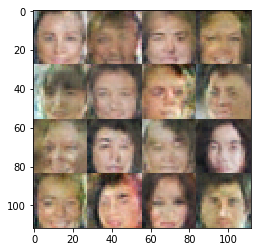

Epoch 0/1... Discriminator Loss: 0.8094... Generator Loss: 1.7216
Epoch 0/1... Discriminator Loss: 1.1016... Generator Loss: 0.7569
Epoch 0/1... Discriminator Loss: 1.1395... Generator Loss: 0.7052
Epoch 0/1... Discriminator Loss: 0.9548... Generator Loss: 0.9401
Epoch 0/1... Discriminator Loss: 0.7520... Generator Loss: 1.7139
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


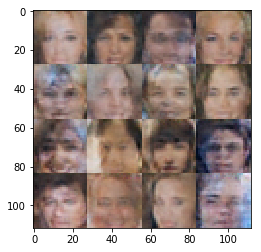

Epoch 0/1... Discriminator Loss: 1.0412... Generator Loss: 0.9680
Epoch 0/1... Discriminator Loss: 0.8453... Generator Loss: 1.3745
Epoch 0/1... Discriminator Loss: 0.8736... Generator Loss: 1.5282
Epoch 0/1... Discriminator Loss: 0.7842... Generator Loss: 1.2799
Epoch 0/1... Discriminator Loss: 0.9987... Generator Loss: 1.0650
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


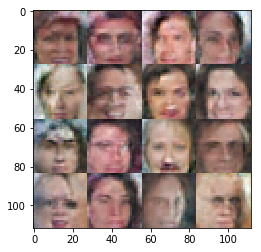

Epoch 0/1... Discriminator Loss: 1.1686... Generator Loss: 0.8677
Epoch 0/1... Discriminator Loss: 0.9366... Generator Loss: 0.9923
Epoch 0/1... Discriminator Loss: 1.0812... Generator Loss: 0.6855
Epoch 0/1... Discriminator Loss: 1.3177... Generator Loss: 0.5489
Epoch 0/1... Discriminator Loss: 0.9846... Generator Loss: 0.8949
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


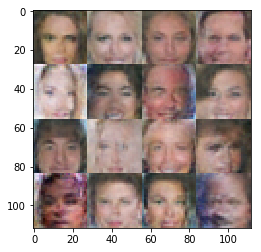

Epoch 0/1... Discriminator Loss: 0.9698... Generator Loss: 1.6223
Epoch 0/1... Discriminator Loss: 1.1698... Generator Loss: 1.7724
Epoch 0/1... Discriminator Loss: 0.8772... Generator Loss: 1.4369
Epoch 0/1... Discriminator Loss: 0.9537... Generator Loss: 0.9503
Epoch 0/1... Discriminator Loss: 1.0361... Generator Loss: 0.8215
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


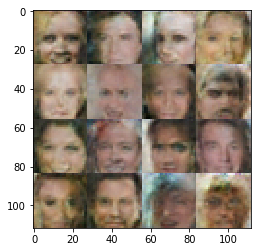

Epoch 0/1... Discriminator Loss: 1.1430... Generator Loss: 0.7312
Epoch 0/1... Discriminator Loss: 0.9852... Generator Loss: 1.4544
Epoch 0/1... Discriminator Loss: 0.8848... Generator Loss: 1.5634
Epoch 0/1... Discriminator Loss: 0.9376... Generator Loss: 0.9092
Epoch 0/1... Discriminator Loss: 1.0478... Generator Loss: 0.8188
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


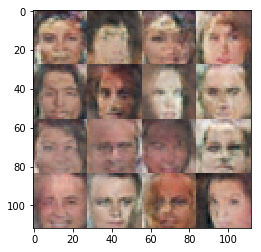

Epoch 0/1... Discriminator Loss: 1.1689... Generator Loss: 0.7961
Epoch 0/1... Discriminator Loss: 0.8148... Generator Loss: 1.7490
Epoch 0/1... Discriminator Loss: 1.0516... Generator Loss: 1.9735
Epoch 0/1... Discriminator Loss: 0.8063... Generator Loss: 1.3792
Epoch 0/1... Discriminator Loss: 1.1804... Generator Loss: 0.7376
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


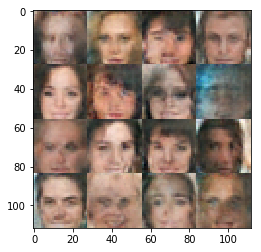

Epoch 0/1... Discriminator Loss: 0.9274... Generator Loss: 1.5470
Epoch 0/1... Discriminator Loss: 0.9940... Generator Loss: 1.0176
Epoch 0/1... Discriminator Loss: 0.9853... Generator Loss: 1.4459
Epoch 0/1... Discriminator Loss: 0.8252... Generator Loss: 2.2456
Epoch 0/1... Discriminator Loss: 0.9644... Generator Loss: 1.4396
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


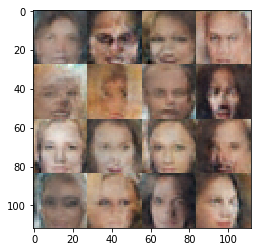

Epoch 0/1... Discriminator Loss: 0.9919... Generator Loss: 0.9816
Epoch 0/1... Discriminator Loss: 0.9739... Generator Loss: 1.2418
Epoch 0/1... Discriminator Loss: 0.9693... Generator Loss: 1.0892
Epoch 0/1... Discriminator Loss: 1.2187... Generator Loss: 0.6417
Epoch 0/1... Discriminator Loss: 0.9076... Generator Loss: 1.0616
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


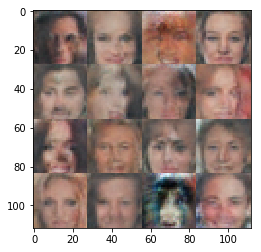

Epoch 0/1... Discriminator Loss: 1.0654... Generator Loss: 0.9287
Epoch 0/1... Discriminator Loss: 0.9692... Generator Loss: 1.1122
Epoch 0/1... Discriminator Loss: 1.0034... Generator Loss: 1.4263
Epoch 0/1... Discriminator Loss: 0.8757... Generator Loss: 1.1698
Epoch 0/1... Discriminator Loss: 0.8248... Generator Loss: 1.1545
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


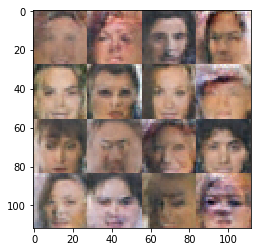

Epoch 0/1... Discriminator Loss: 1.0796... Generator Loss: 0.8089
Epoch 0/1... Discriminator Loss: 0.9334... Generator Loss: 1.3560
Epoch 0/1... Discriminator Loss: 0.6991... Generator Loss: 1.4675
Epoch 0/1... Discriminator Loss: 1.1129... Generator Loss: 0.6862
Epoch 0/1... Discriminator Loss: 1.2472... Generator Loss: 0.6076
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


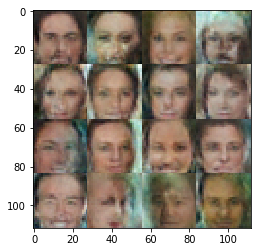

Epoch 0/1... Discriminator Loss: 1.0157... Generator Loss: 0.8998
Epoch 0/1... Discriminator Loss: 1.1723... Generator Loss: 0.6251
Epoch 0/1... Discriminator Loss: 0.8691... Generator Loss: 1.2939
Epoch 0/1... Discriminator Loss: 1.0417... Generator Loss: 0.8640
Epoch 0/1... Discriminator Loss: 0.8180... Generator Loss: 1.2925
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


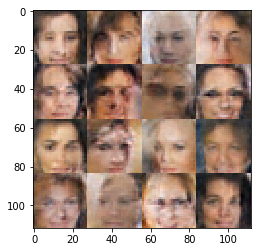

Epoch 0/1... Discriminator Loss: 0.9514... Generator Loss: 1.5585
Epoch 0/1... Discriminator Loss: 1.2239... Generator Loss: 0.7565
Epoch 0/1... Discriminator Loss: 1.0567... Generator Loss: 0.8279
Epoch 0/1... Discriminator Loss: 0.8917... Generator Loss: 0.9908
Epoch 0/1... Discriminator Loss: 0.8595... Generator Loss: 1.6565
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


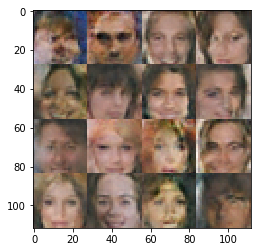

Epoch 0/1... Discriminator Loss: 0.9186... Generator Loss: 1.3918
Epoch 0/1... Discriminator Loss: 0.9280... Generator Loss: 0.8340
Epoch 0/1... Discriminator Loss: 1.0105... Generator Loss: 0.9463
Epoch 0/1... Discriminator Loss: 0.8245... Generator Loss: 1.4110
Epoch 0/1... Discriminator Loss: 1.0060... Generator Loss: 1.2150
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


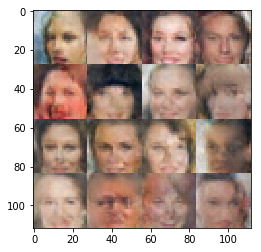

Epoch 0/1... Discriminator Loss: 0.8375... Generator Loss: 1.2118
Epoch 0/1... Discriminator Loss: 1.6260... Generator Loss: 0.3874
Epoch 0/1... Discriminator Loss: 1.2948... Generator Loss: 0.5668
Epoch 0/1... Discriminator Loss: 0.8838... Generator Loss: 1.2788
Epoch 0/1... Discriminator Loss: 0.9210... Generator Loss: 1.5219
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


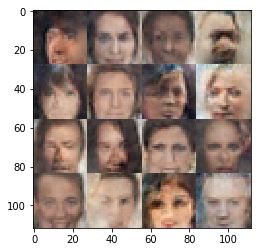

Epoch 0/1... Discriminator Loss: 1.1602... Generator Loss: 1.4216
Epoch 0/1... Discriminator Loss: 0.8169... Generator Loss: 1.2956
Epoch 0/1... Discriminator Loss: 0.8541... Generator Loss: 1.6562
Epoch 0/1... Discriminator Loss: 0.9624... Generator Loss: 0.9281
Epoch 0/1... Discriminator Loss: 0.8526... Generator Loss: 2.1637
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


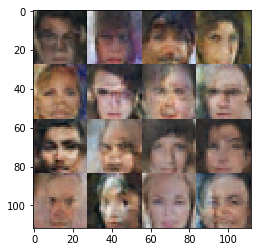

Epoch 0/1... Discriminator Loss: 0.9604... Generator Loss: 0.9792
Epoch 0/1... Discriminator Loss: 0.9169... Generator Loss: 1.1874
Epoch 0/1... Discriminator Loss: 0.9302... Generator Loss: 1.2111
Epoch 0/1... Discriminator Loss: 1.2373... Generator Loss: 0.6528
Epoch 0/1... Discriminator Loss: 1.0314... Generator Loss: 0.8992
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


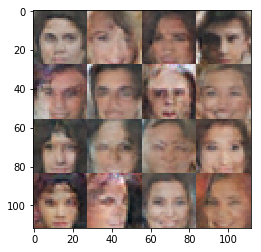

Epoch 0/1... Discriminator Loss: 1.3242... Generator Loss: 0.5714
Epoch 0/1... Discriminator Loss: 1.3668... Generator Loss: 0.5671
Epoch 0/1... Discriminator Loss: 0.8749... Generator Loss: 1.2153
Epoch 0/1... Discriminator Loss: 0.9061... Generator Loss: 1.3150
Epoch 0/1... Discriminator Loss: 0.9387... Generator Loss: 1.4175
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


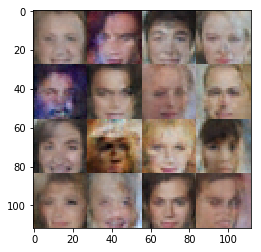

Epoch 0/1... Discriminator Loss: 0.9545... Generator Loss: 1.0021
Epoch 0/1... Discriminator Loss: 0.9343... Generator Loss: 0.9732
Epoch 0/1... Discriminator Loss: 1.0085... Generator Loss: 0.9016
Epoch 0/1... Discriminator Loss: 0.9357... Generator Loss: 2.1368
Epoch 0/1... Discriminator Loss: 0.8835... Generator Loss: 1.0212
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


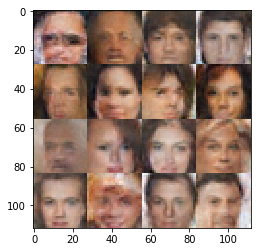

Epoch 0/1... Discriminator Loss: 0.8212... Generator Loss: 1.4501
Epoch 0/1... Discriminator Loss: 1.0720... Generator Loss: 1.8701
Epoch 0/1... Discriminator Loss: 0.9176... Generator Loss: 1.5314
Epoch 0/1... Discriminator Loss: 1.1419... Generator Loss: 0.6599
Epoch 0/1... Discriminator Loss: 0.8169... Generator Loss: 1.3113
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


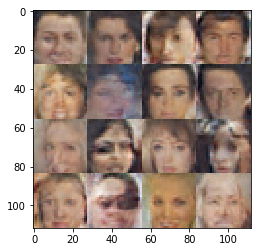

Epoch 0/1... Discriminator Loss: 0.9180... Generator Loss: 1.2201
Epoch 0/1... Discriminator Loss: 0.9353... Generator Loss: 1.0986
Epoch 0/1... Discriminator Loss: 0.9499... Generator Loss: 1.2193
Epoch 0/1... Discriminator Loss: 1.0863... Generator Loss: 0.7705
Epoch 0/1... Discriminator Loss: 1.2624... Generator Loss: 0.6151
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


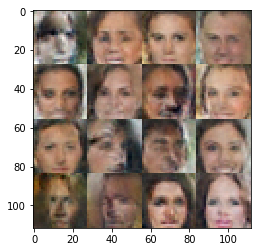

Epoch 0/1... Discriminator Loss: 0.7661... Generator Loss: 1.3360
Epoch 0/1... Discriminator Loss: 0.9144... Generator Loss: 1.1196
Epoch 0/1... Discriminator Loss: 0.8234... Generator Loss: 1.1923
Epoch 0/1... Discriminator Loss: 1.1244... Generator Loss: 0.6927
Epoch 0/1... Discriminator Loss: 1.0750... Generator Loss: 1.9764
x1 (?, 7, 7, 512)
x2 (?, 14, 14, 128)
x3 (?, 28, 28, 32)
logits (?, 28, 28, 3)


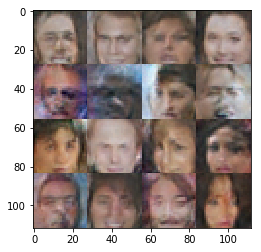

Epoch 0/1... Discriminator Loss: 1.0904... Generator Loss: 0.9663
Epoch 0/1... Discriminator Loss: 0.9096... Generator Loss: 1.3340
CPU times: user 8min 15s, sys: 1min 51s, total: 10min 7s
Wall time: 12min 48s


In [64]:
%%time
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
alpha=0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
print("finished loading images.")

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.